# Causal-DGS-SMOTE: A Causality-Aware Oversampling Method
**Course:** Special Topics in Computer Engineering

* Şevval Aydoğan (210201045)
* Seray Üstün (210201063)
* Yusuf Buğra Öztürk (210201078)

---
### Abstract
This notebook implements the experimental framework for **Causal-DGS-SMOTE**, a oversampling technique designed to preserve structural integrity in imbalanced datasets. We compare our method against SMOTE, Borderline-SMOTE, and ADASYN across multiple benchmark datasets and noise levels.

## 1. Environment Setup
Importing necessary libraries for data manipulation, machine learning models, and evaluation metrics. We also configure the environment settings and Google Drive connection.

In [ ]:
# --- CELL 1: Libraries & Setup ---
import numpy as np
import pandas as pd
import warnings
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
# imblearn library is required: !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from scipy.stats import spearmanr
from google.colab import drive
import os

# Drive Connection
if not os.path.exists('/content/gdrive'):
    drive.mount('/content/gdrive')

# Settings / Configuration
warnings.filterwarnings('ignore')
np.seterr(divide='ignore', invalid='ignore')
np.random.seed(42)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Data Path
drive_path = '/content/gdrive/MyDrive/'
data_folder = drive_path + 'data/'

print("Libraries loaded and settings configured.")

Mounted at /content/gdrive
Libraries loaded and settings configured.


## 2. Helper Functions
This section defines utility functions used throughout the experiments:
* **`add_noise`**: Injects Gaussian noise to test model robustness.
* **`load_dat_file`**: Parses `.dat` files and prepares them for binary classification.
* **`calculate_metrics`**: Computes Recall, Precision, F1-Score, G-Mean, and AUC.

In [ ]:
# --- CELL 2: Helper Functions ---

# --- NOISE INJECTION FUNCTION ---
def add_noise(X, noise_level, random_state=42):
    """Adds Gaussian noise proportional to the standard deviation of each feature."""
    if noise_level <= 0:
        return X

    np.random.seed(random_state)

    X_std = np.std(X, axis=0)
    X_std[X_std == 0] = 1e-8

    noise_magnitude = noise_level / 100.0

    noise = np.random.normal(0, 1, size=X.shape)
    scaled_noise = noise * (X_std * noise_magnitude)

    return X + scaled_noise

# --- DAT LOADER ---
def load_dat_file(filename):
    """Loads DAT files ensuring proper formatting and binary classification."""
    filepath = os.path.join(data_folder, filename)
    data_lines = []
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
    except Exception as e:
        raise ValueError(f"File reading error: {e}. Path: {filepath}")

    for line in lines:
        stripped_line = line.strip()
        if not stripped_line.startswith('@') and stripped_line:
            data_lines.append(stripped_line)

    df = pd.DataFrame([line.split(',') for line in data_lines])
    label_column_index = df.shape[1] - 1
    df = df.apply(lambda x: x.astype(str).str.strip().str.replace('"', '').str.replace("'", ""))

    X = df.iloc[:, :label_column_index].apply(pd.to_numeric, errors='coerce').values
    y_raw = df.iloc[:, label_column_index].values

    nan_rows = np.any(np.isnan(X), axis=1)
    X = X[~nan_rows]
    y_raw = y_raw[~nan_rows]

    if y_raw.dtype == object:
        y, _ = pd.factorize(y_raw)
    else:
        y = y_raw.astype(int)

    if len(np.unique(y)) != 2:
        raise ValueError("Binary classification expected (load_dat_file)")

    counts = Counter(y)
    minority_label = min(counts, key=counts.get)
    y = np.where(y == minority_label, 1, 0)

    if len(X) < 50 or np.sum(y) < 5:
        raise ValueError("Too few samples or minority class samples.")

    return X, y

# --- METRICS ---
def calculate_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        return 0, 0, 0, 0, 0

    sensitivity = tp / (tp + fn) if (tp + fn) else 0 # Recall
    specificity = tn / (tn + fp) if (tn + fp) else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    g_mean = np.sqrt(sensitivity * specificity)
    f1 = 2*(precision*sensitivity)/(precision+sensitivity) if (precision+sensitivity) else 0

    try: auc = roc_auc_score(y_true, y_prob)
    except: auc = 0

    return sensitivity, precision, f1, g_mean, auc

print("Helper functions defined.")

Helper functions defined.


## 3. Proposed Algorithm: Causal-DGS-SMOTE
Here, we implement the proposed **Causal-DGS-SMOTE** algorithm.
Key components include:
1.  **Causal Discovery:** Using Spearman's Rank Correlation to model feature dependencies.
2.  **Adaptive Weighting:** Calculating $\alpha_{final}$ based on **Robustness**, **Risk**, and **Density** factors.
3.  **Consistency Check:** Filtering out synthetic samples that violate the statistical structure of the minority class.

In [ ]:
# --- CELL 3: Causal-DGS-SMOTE Algorithm ---

class SimpleCausalDiscovery:
    def __init__(self, threshold=0.3):
        self.threshold = threshold
        self.causal_matrix = None
        self.feature_importance = None

    def fit(self, X, y):
        n_features = X.shape[1]
        self.causal_matrix = np.zeros((n_features, n_features))

        for i in range(n_features):
            for j in range(n_features):
                if i != j:
                    try:
                        corr, _ = spearmanr(X[:, i], X[:, j])
                        if not np.isnan(corr) and abs(corr) > self.threshold:
                            self.causal_matrix[i, j] = corr
                    except:
                        pass

        self.feature_importance = np.zeros(n_features)
        for i in range(n_features):
            try:
                corr, _ = spearmanr(X[:, i], y)
                if not np.isnan(corr):
                    self.feature_importance[i] = abs(corr)
            except:
                pass
        return self

    def get_causal_neighbors(self, feature_idx, top_k=3):
        strengths = np.abs(self.causal_matrix[feature_idx])
        top_indices = np.argsort(strengths)[::-1][:top_k]
        return top_indices, strengths[top_indices]

class CausalDGSSMOTE:
    def __init__(self, sampling_strategy=1.0, k_neighbors=5, k1_min=3, k2_maj=3,
                 causal_weight='auto', causal_threshold=0.25, consistency_threshold=0.4,
                 max_syn_limit=None, random_state=42):
        self.sampling_strategy = sampling_strategy
        self.k_neighbors = k_neighbors
        self.k1_min = k1_min
        self.k2_maj = k2_maj
        self.causal_weight_mode = causal_weight
        self.causal_weight = None
        self.consistency_threshold = consistency_threshold
        self.max_syn_limit = max_syn_limit
        self.random_state = random_state
        self.causal_discovery = SimpleCausalDiscovery(threshold=causal_threshold)

    def _causal_interpolation(self, xi, xj, alpha):
        n_features = len(xi)
        x_new = np.zeros(n_features)
        for f in range(n_features):
            standard_value = xi[f] + alpha * (xj[f] - xi[f]) * np.random.rand()
            neighbors, strengths = self.causal_discovery.get_causal_neighbors(f, top_k=2)

            if len(neighbors) > 0 and np.sum(strengths) > 0:
                causal_influence = 0
                for neighbor_idx, strength in zip(neighbors, strengths):
                    if neighbor_idx < n_features:
                        neighbor_change = xj[neighbor_idx] - xi[neighbor_idx]
                        causal_influence += strength * neighbor_change
                causal_influence /= (np.sum(strengths) + 1e-8)
                causal_value = standard_value + self.causal_weight * causal_influence
                x_new[f] = causal_value
            else:
                x_new[f] = standard_value
        return x_new

    def _calculate_causal_consistency(self, x_new, X_min):
        n_features = len(x_new)
        consistency_score = 0
        for f in range(n_features):
            std_dev = np.std(X_min[:, f])
            mean_val = np.mean(X_min[:, f])
            deviation = abs(x_new[f] - mean_val) / (std_dev + 1e-8)
            consistency_score += (1 - min(1, deviation / 2.0))
        return consistency_score / n_features

    def _estimate_causal_strength(self, X, y):
        n_features = X.shape[1]
        strong_correlations = 0
        total_pairs = 0
        for i in range(n_features):
            for j in range(i+1, n_features):
                try:
                    corr, _ = spearmanr(X[:, i], X[:, j])
                    if not np.isnan(corr):
                        if abs(corr) > 0.3:
                            strong_correlations += 1
                        total_pairs += 1
                except:
                    pass
        causal_ratio = strong_correlations / total_pairs if total_pairs > 0 else 0
        size_factor = min(1.0, len(X) / 200)
        if causal_ratio > 0.3:
            weight = 0.4 * size_factor
        elif causal_ratio > 0.15:
            weight = 0.2 * size_factor
        else:
            weight = 0.05 * size_factor
        return weight, causal_ratio

    def fit_resample(self, X, y):
        np.random.seed(self.random_state)
        self.causal_discovery.fit(X, y)
        if self.causal_weight_mode == 'auto':
            self.causal_weight, causal_ratio = self._estimate_causal_strength(X, y)
        else:
            self.causal_weight = self.causal_weight_mode
            causal_ratio = 0

        counts = Counter(y)
        minority = min(counts, key=counts.get)
        majority = 1 - minority
        X_min = X[y == minority]
        n_min = len(X_min)
        n_maj = len(X[y == majority])

        n_syn_ideal = int(self.sampling_strategy * n_maj) - n_min
        n_syn = np.min([n_syn_ideal, self.max_syn_limit]) if self.max_syn_limit else n_syn_ideal
        if n_syn <= 0: return X, y

        k1_min_actual = n_min - 1 if n_min < self.k1_min + 1 else self.k1_min
        if k1_min_actual < 1: return X, y

        knn_all = NearestNeighbors(n_neighbors=self.k_neighbors + 1).fit(X)
        knn_min = NearestNeighbors(n_neighbors=k1_min_actual + 1).fit(X_min)
        knn_maj = NearestNeighbors(n_neighbors=self.k2_maj + 1).fit(X[y == majority])

        X_syn = []
        synth_indices = np.random.choice(n_min, size=int(n_syn * 1.5), replace=True)

        for i in synth_indices:
            xi = X_min[i]
            d_min, _ = knn_min.kneighbors(xi.reshape(1, -1))
            D_min_mean = np.mean(d_min[0][1:k1_min_actual + 1])
            d_maj, _ = knn_maj.kneighbors(xi.reshape(1, -1))
            D_maj_median = np.median(d_maj[0][:self.k2_maj])
            ratio = D_min_mean / (D_maj_median + 1e-6)
            alpha_robust = np.min([1, np.max([0, 1 - ratio])])
            _, ind_all = knn_all.kneighbors(xi.reshape(1, -1))
            neighbor_labels = y[ind_all[0][1:self.k_neighbors + 1]]
            R_Risk = np.sum(neighbor_labels == majority) / self.k_neighbors
            Count_Min = np.sum(neighbor_labels == minority)
            G_Factor = np.log2(1 + Count_Min / self.k_neighbors)
            alpha_final = alpha_robust * (1 - R_Risk) * G_Factor
            _, ind_syn = knn_min.kneighbors(xi.reshape(1, -1))
            valid = ind_syn[0][1:]
            if len(valid) == 0: continue
            xj = X_min[np.random.choice(valid)]
            X_synthetic = self._causal_interpolation(xi, xj, alpha_final)
            consistency = self._calculate_causal_consistency(X_synthetic, X_min)
            if consistency >= self.consistency_threshold:
                X_syn.append(X_synthetic)
            if len(X_syn) >= n_syn: break

        if len(X_syn) == 0: return X, y
        X_syn = np.vstack(X_syn[:n_syn])
        y_syn = np.full(X_syn.shape[0], minority)
        return np.vstack([X, X_syn]), np.concatenate([y, y_syn])

print("Causal-DGS-SMOTE algorithm defined.")

Causal-DGS-SMOTE algorithm defined.


## 4. Experiment Logic
The `run_comparative_experiment` function manages the training and evaluation pipeline. It:
1.  Splits data into training and testing sets.
2.  Applies SMOTE, Borderline-SMOTE, ADASYN, and Causal-DGS-SMOTE.
3.  Trains a Logistic Regression classifier on the balanced data.
4.  Reports comparative metrics.

In [ ]:
# --- CELL 4: Experiment Logic ---

def run_comparative_experiment(X, y, dataset_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    sampling_strategy = "not majority"

    methods = {
        "SMOTE": SMOTE(sampling_strategy=sampling_strategy, random_state=42),
        "BSM": BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42),
        "ADASYN": ADASYN(sampling_strategy=sampling_strategy, random_state=42),
        "Causal-DGS": CausalDGSSMOTE(
            sampling_strategy=1.0, causal_weight='auto', causal_threshold=0.25,
            consistency_threshold=0.4, random_state=42
        )
    }

    results = {}
    metrics = ['Recall', 'Precision', 'F1', 'G-Mean', 'AUC']

    clf = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000)

    print(f"\n{'='*115}")
    print(f"  Dataset: {dataset_name}")
    print(f"{'='*115}")

    for name, sampler in methods.items():
        try:
            if name == "Causal-DGS":
                X_res, y_res = sampler.fit_resample(X_train, y_train)
            else:
                X_res, y_res = sampler.fit_resample(X_train, y_train)

            # Skip if only one class remains after resampling
            if len(np.unique(y_res)) < 2:
                print(f"Warning: Only one class remaining after resampling for {name}.")
                continue

            clf.fit(X_res, y_res)
            pred = clf.predict(X_test)
            prob = clf.predict_proba(X_test)[:,1]

            results[name] = dict(zip(metrics, calculate_metrics(y_test, pred, prob)))

        except ValueError as e:
            print(f"Warning: {name} could not be executed. Error: {e}")
            continue

    # Table Header (Extended: vs SMOTE included)
    print(f"\n{'Metric':<10} | {'SMOTE':>8} | {'BSM':>8} | {'ADASYN':>8} | {'Causal-DGS':>10} | {'vs SMOTE':>10} | {'vs BSM':>10} | {'vs ADASYN':>10}")
    print("-" * 115)

    comparison_methods = ["SMOTE", "BSM", "ADASYN"]

    # Print Results
    for m in metrics:
        # Causal-DGS value (if exists)
        causal_val = results.get('Causal-DGS', {}).get(m, 0)

        row_str = f"{m:<10} | "

        # Other methods
        vals = {}
        for method in comparison_methods:
            val = results.get(method, {}).get(m, 0)
            vals[method] = val
            row_str += f"{val:>8.4f} | "

        row_str += f"{causal_val:>10.4f} | "

        # Calculate Differences (If applicable)

        # 1. vs SMOTE
        if vals['SMOTE'] > 0:
            diff_smote = (causal_val - vals['SMOTE']) / vals['SMOTE'] * 100
            row_str += f"{diff_smote:>+9.2f}% | "
        else:
            row_str += "    N/A    | "

        # 2. vs BSM
        if vals['BSM'] > 0:
            diff_bsm = (causal_val - vals['BSM']) / vals['BSM'] * 100
            row_str += f"{diff_bsm:>+9.2f}% | "
        else:
            row_str += "    N/A    | "

        # 3. vs ADASYN
        if vals['ADASYN'] > 0:
            diff_ada = (causal_val - vals['ADASYN']) / vals['ADASYN'] * 100
            row_str += f"{diff_ada:>+9.2f}%"
        else:
            row_str += "    N/A"

        print(row_str)

    return results

## 5. Execution on Benchmark Datasets
We execute the comparison across 6 datasets (`Cleveland`, `Ecoli`, `Glass`, `Segment`, `Pima`).
* **Note:** For the `Ecoli2` dataset, we specifically test noise robustness by injecting 5% and 10% noise.

In [ ]:
# --- CELL 5: Execute Experiments ---

# List of Datasets
all_files = [
    ('cleveland-0_vs_4.dat', 'dat'),
    ('ecoli-0-1-4-6_vs_5.dat', 'dat'),
    ('ecoli2.dat', 'dat'),
    ('glass6.dat', 'dat'),
    ('segment0.dat', 'dat'),
    ('pima.dat', 'dat'),
]

datasets_to_run = []
for filename, ftype in all_files:
    if ftype == 'dat':
        # Lazy loading with Lambda
        datasets_to_run.append((f"{filename}", lambda f=filename: load_dat_file(f)))

all_results = {}
noise_levels_full = [0, 5, 10]
noise_levels_single = [0]

print("EXPERIMENT STARTING...\n")

for name, loader in datasets_to_run:
    # Noise test for Ecoli2, clean data for others
    if 'ecoli2' in name:
        current_noise_levels = noise_levels_full
    else:
        current_noise_levels = noise_levels_single

    try:
        # 1. Load Data
        X_orig, y_orig = loader()

        # 2. Normalization (Z-Score)
        X_orig = (X_orig - X_orig.mean(axis=0)) / (np.std(X_orig, axis=0) + 1e-8)

        # 3. Noise Loop
        for noise in current_noise_levels:
            if noise > 0:
                dataset_label = f"{name} ({noise}% Noise)"
                X_process = add_noise(X_orig, noise)
            else:
                dataset_label = f"{name} (Original)"
                X_process = X_orig

            # 4. Run Experiment
            all_results[dataset_label] = run_comparative_experiment(X_process, y_orig, dataset_label)

    except Exception as e:
        print(f"GENERAL ERROR ({name}): {e}")

EXPERIMENT STARTING...


  Dataset: cleveland-0_vs_4.dat (Original)

Metric     |    SMOTE |      BSM |   ADASYN | Causal-DGS |   vs SMOTE |     vs BSM |  vs ADASYN
-------------------------------------------------------------------------------------------------------------------
Recall     |   0.7500 |   0.7500 |   0.7500 |     0.7500 |     +0.00% |     +0.00% |     +0.00%
Precision  |   0.7500 |   0.7500 |   0.6000 |     1.0000 |    +33.33% |    +33.33% |    +66.67%
F1         |   0.7500 |   0.7500 |   0.6667 |     0.8571 |    +14.29% |    +14.29% |    +28.57%
G-Mean     |   0.8570 |   0.8570 |   0.8478 |     0.8660 |     +1.06% |     +1.06% |     +2.15%
AUC        |   0.9740 |   0.9740 |   0.9740 |     0.9740 |     +0.00% |     +0.00% |     +0.00%

  Dataset: ecoli-0-1-4-6_vs_5.dat (Original)

Metric     |    SMOTE |      BSM |   ADASYN | Causal-DGS |   vs SMOTE |     vs BSM |  vs ADASYN
------------------------------------------------------------------------------------------------

## 6. Visualization & Analysis
Visualizing the results to demonstrate the effectiveness of Causal-DGS-SMOTE.
* **Noise Robustness Plot:** Shows Precision stability under noise.
* **PCA Projections:** Visualizes the structural integrity of generated synthetic samples compared to the original minority distribution.

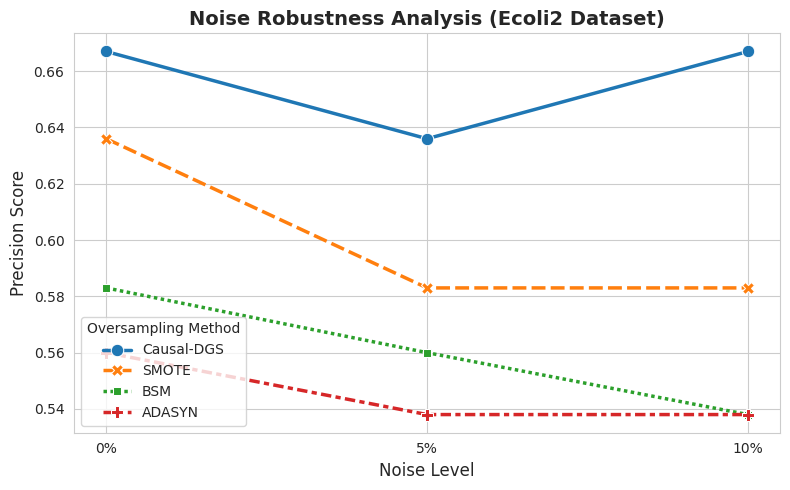

In [ ]:
# --- CELL 6: Noise Robustness Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from Ecoli2 Noise Experiments
data = {
    'Noise Level': ['0%', '5%', '10%', '0%', '5%', '10%', '0%', '5%', '10%', '0%', '5%', '10%'],
    'Method': ['Causal-DGS']*3 + ['SMOTE']*3 + ['BSM']*3 + ['ADASYN']*3,
    'Precision': [0.667, 0.636, 0.667,  # Causal-DGS
                  0.636, 0.583, 0.583,  # SMOTE
                  0.583, 0.560, 0.538,  # BSM
                  0.560, 0.538, 0.538]  # ADASYN
}

df = pd.DataFrame(data)

# Plot Settings
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

# Line Plot
sns.lineplot(data=df, x='Noise Level', y='Precision', hue='Method', style='Method',
             markers=True, linewidth=2.5, markersize=9)

# Titles and Labels
plt.title('Noise Robustness Analysis (Ecoli2 Dataset)', fontsize=14, fontweight='bold')
plt.ylabel('Precision Score', fontsize=12)
plt.xlabel('Noise Level', fontsize=12)
plt.legend(title='Oversampling Method', loc='lower left')

# Save and Show
plt.tight_layout()
plt.savefig('noise_robustness_plot.png', dpi=300)
plt.show()


=== Visualizing: cleveland-0_vs_4.dat ===


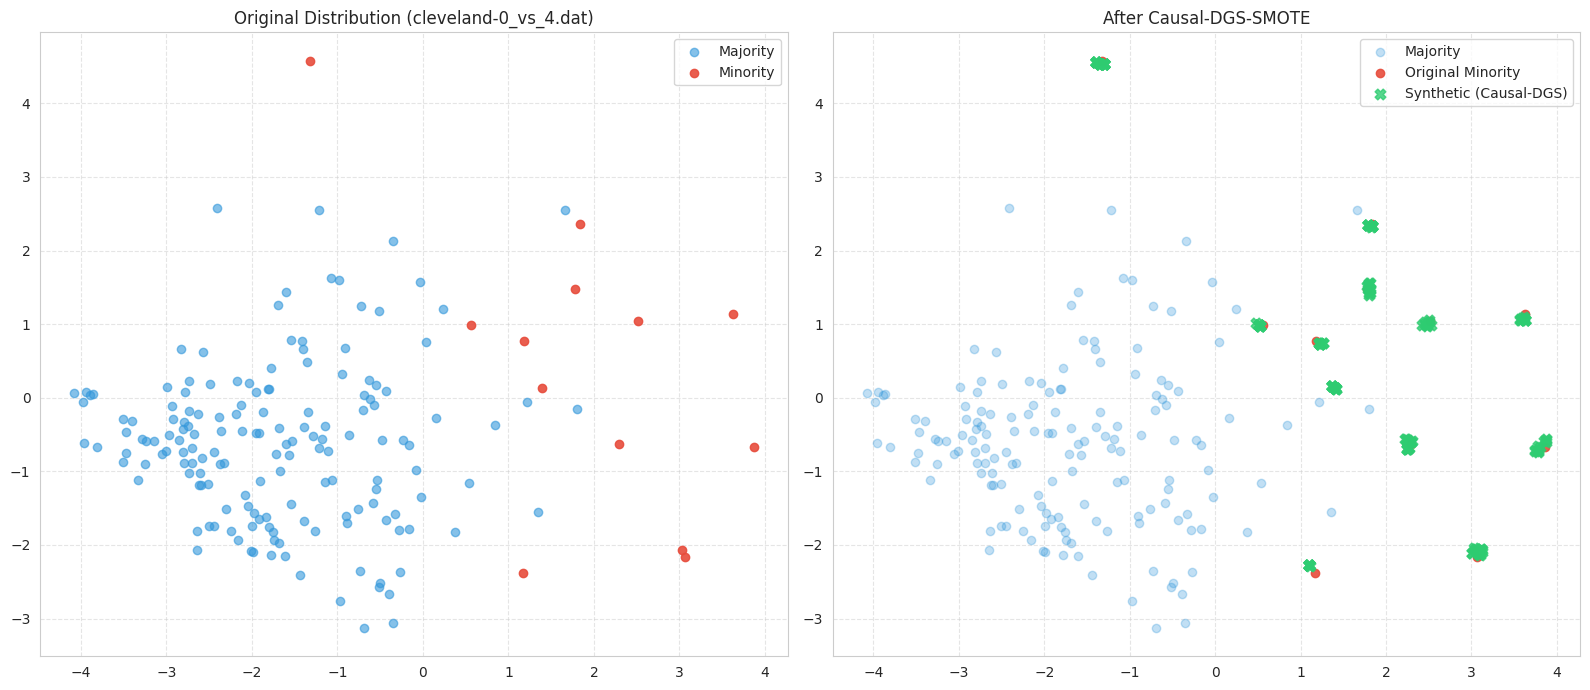


=== Visualizing: ecoli-0-1-4-6_vs_5.dat ===


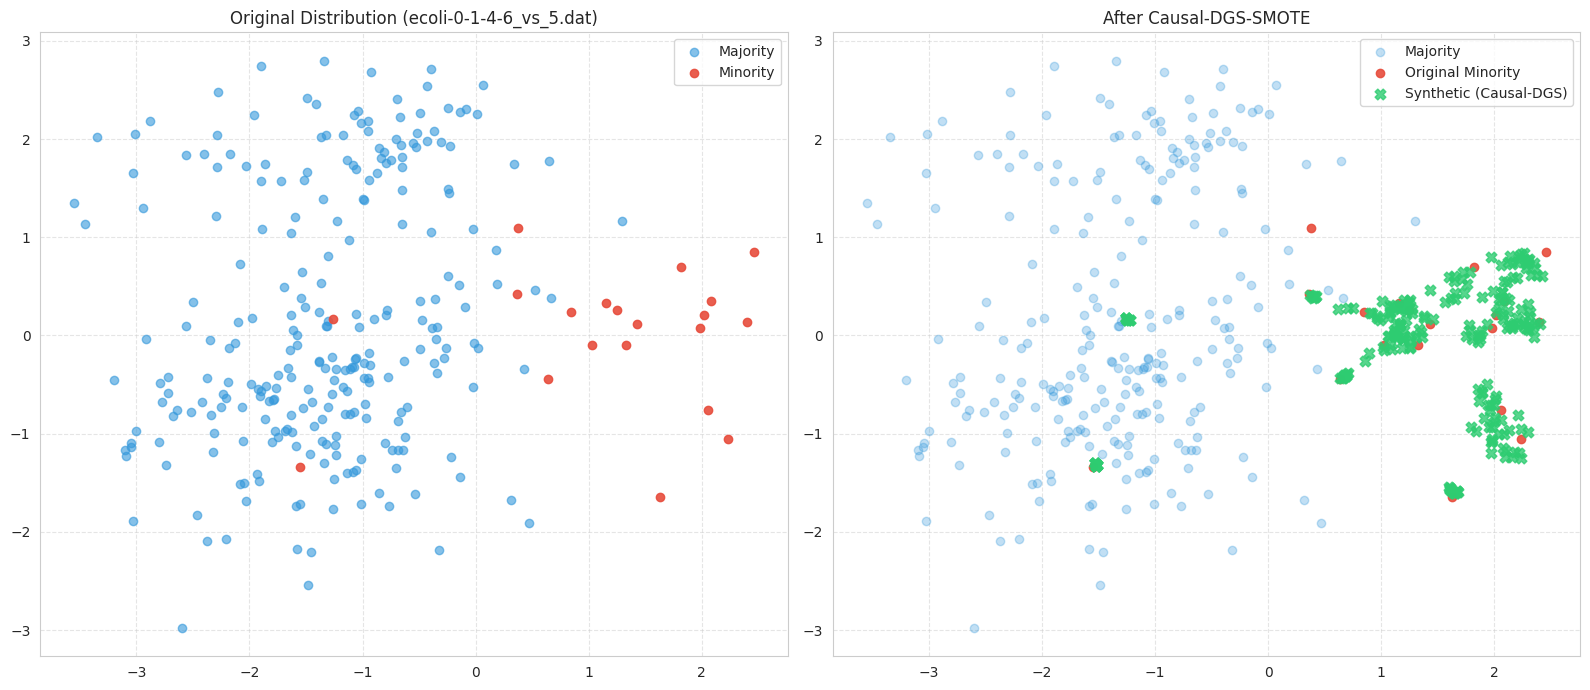


=== Visualizing: ecoli2.dat ===


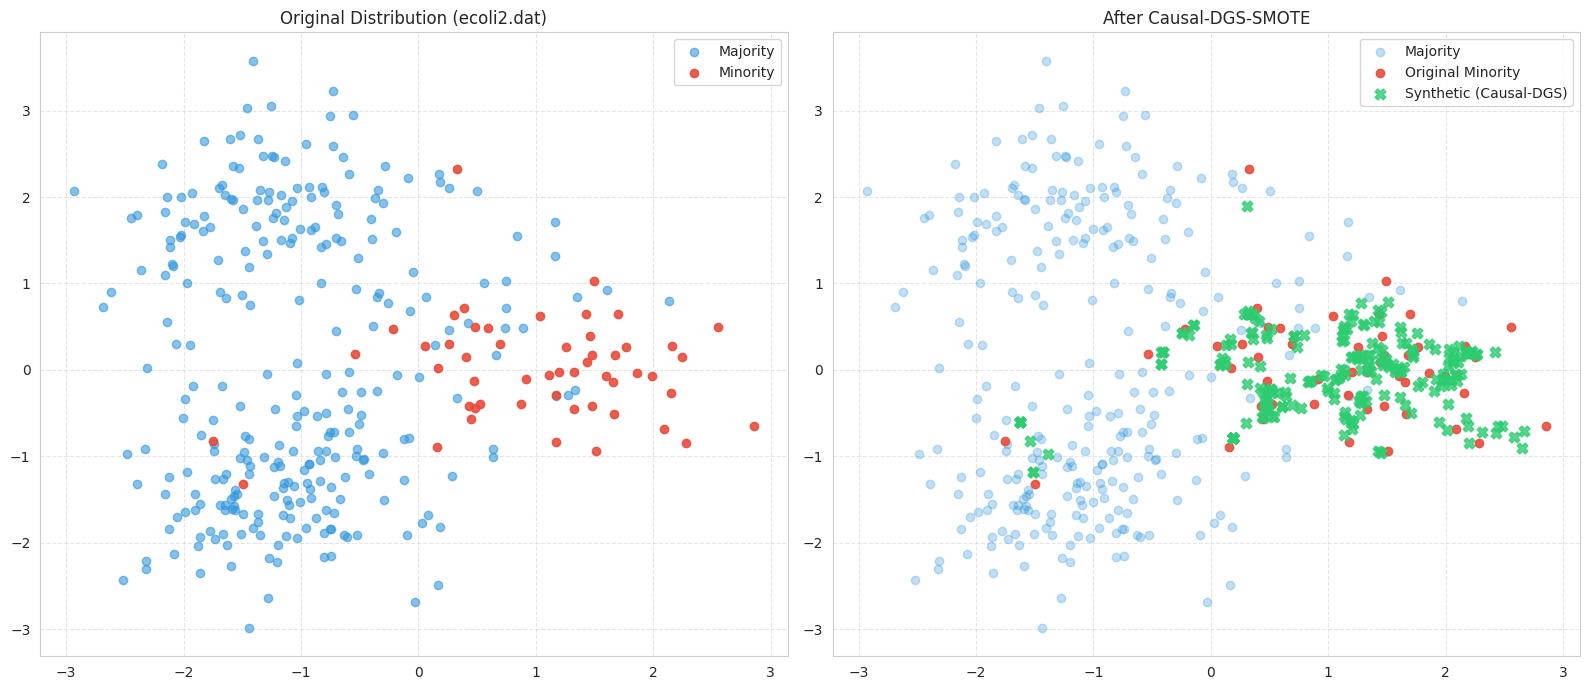


=== Visualizing: glass6.dat ===


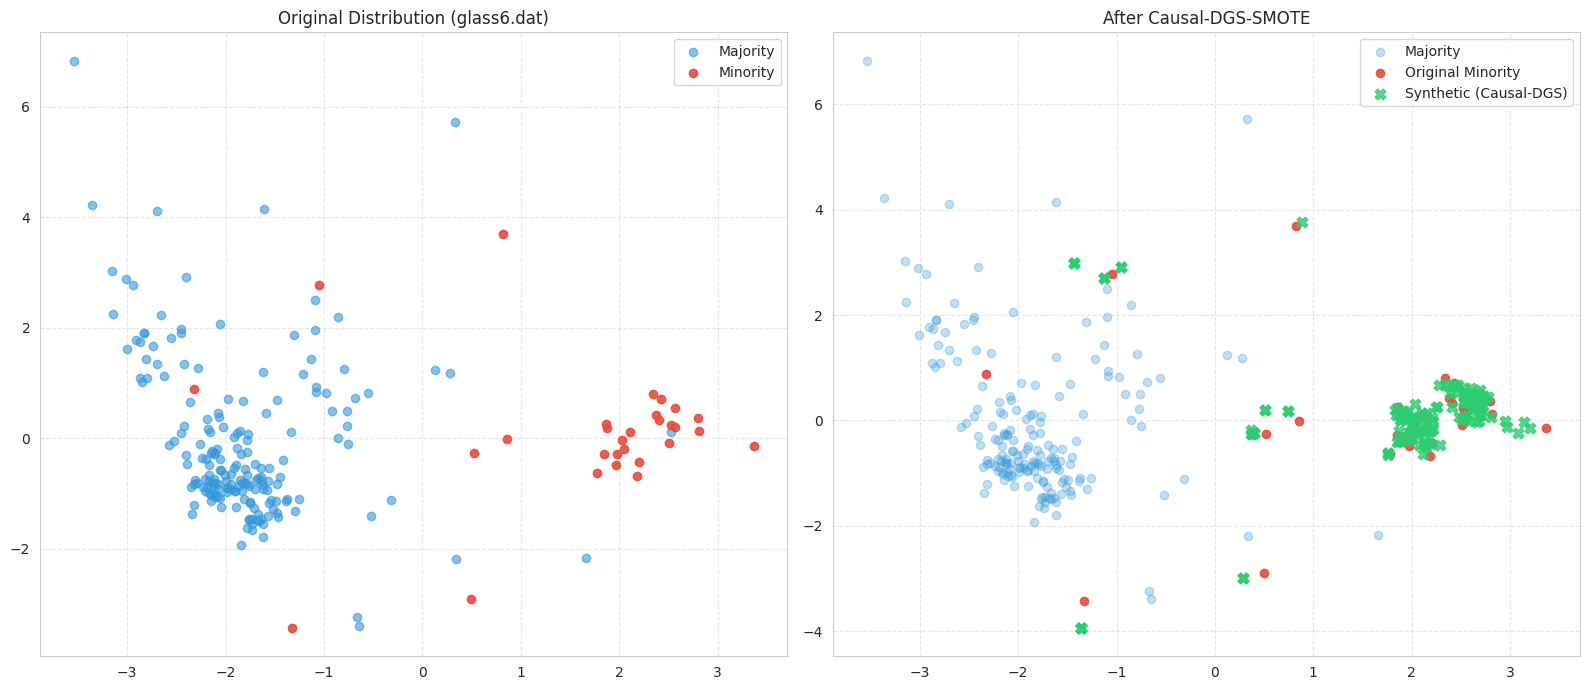


=== Visualizing: segment0.dat ===


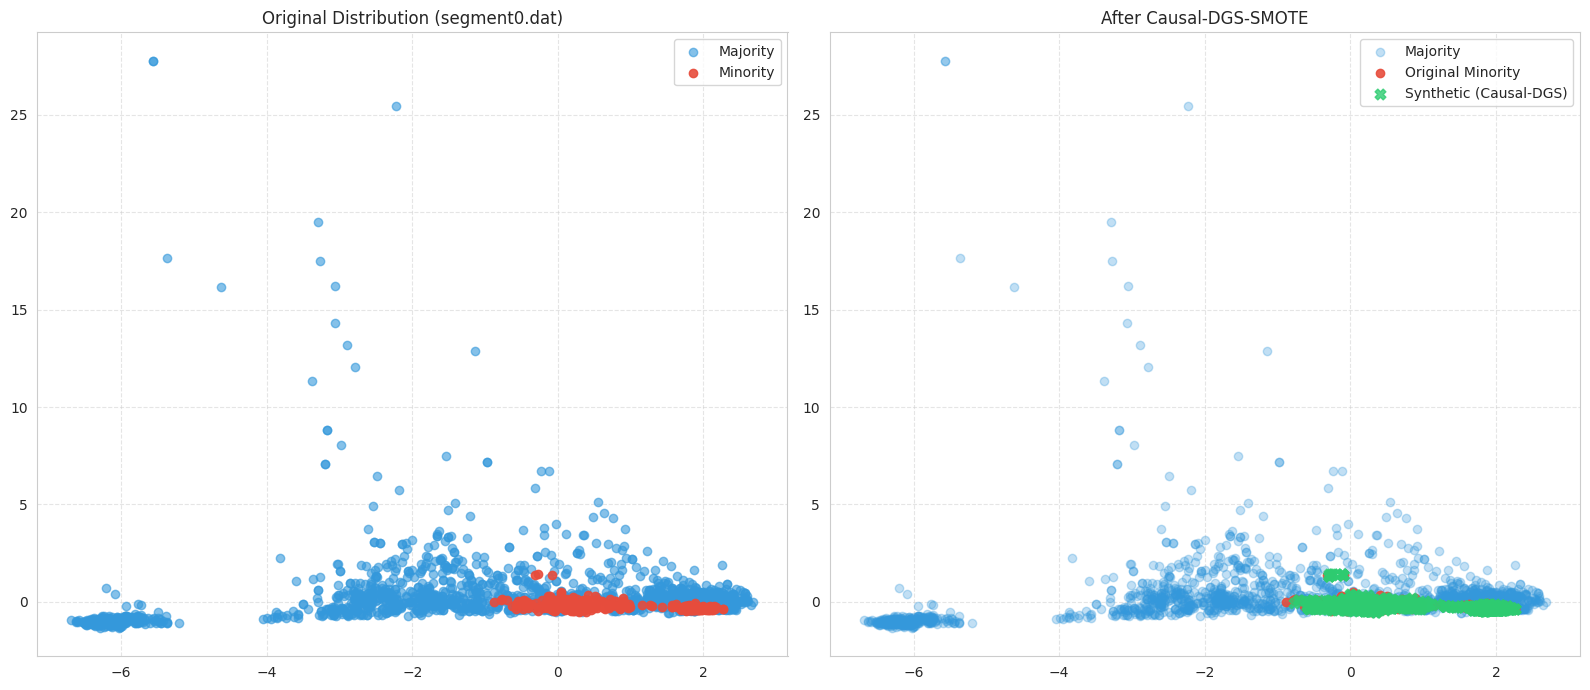


=== Visualizing: pima.dat ===


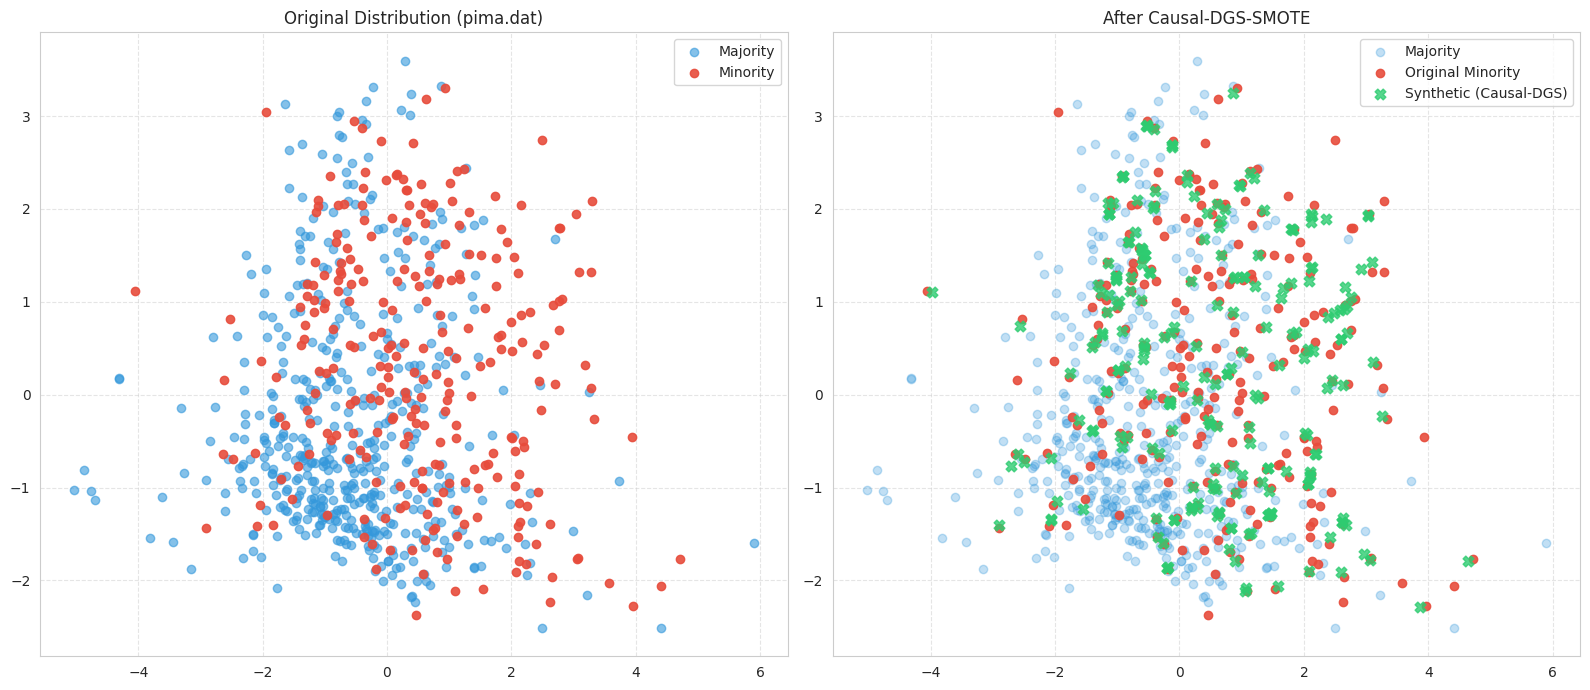

In [ ]:
# --- CELL 7: PCA Visualization of Datasets ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import os

# List of datasets to visualize
datasets = [
    "cleveland-0_vs_4.dat",
    "ecoli-0-1-4-6_vs_5.dat",
    "ecoli2.dat",
    "glass6.dat",
    "segment0.dat",
    "pima.dat"
]

def visualize_dataset(filename):
    print(f"\n=== Visualizing: {filename} ===")

    try:
        # Load Data
        X, y = load_dat_file(filename)

        # Normalization
        X = (X - X.mean(axis=0)) / (np.std(X, axis=0) + 1e-8)

        # Initialize Causal-DGS-SMOTE
        causal_dgs = CausalDGSSMOTE(
            sampling_strategy=1.0,
            causal_weight='auto',
            causal_threshold=0.25,
            consistency_threshold=0.4,
            random_state=42
        )

        # Fit and Resample
        X_res, y_res = causal_dgs.fit_resample(X, y)

        # Separate Original vs Synthetic
        n_original = len(X)
        X_syn = X_res[n_original:]
        y_syn = y_res[n_original:]

        # Apply PCA for 2D Projection
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(X_res)

        X_orig_vis = X_vis[:n_original]
        X_syn_vis = X_vis[n_original:]

        # --- PLOTTING ---
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        # Plot A: Original Data Distribution
        axes[0].scatter(X_orig_vis[y == 0, 0], X_orig_vis[y == 0, 1],
                        c='#3498db', label='Majority', alpha=0.6)
        axes[0].scatter(X_orig_vis[y == 1, 0], X_orig_vis[y == 1, 1],
                        c='#e74c3c', label='Minority', alpha=0.9)

        axes[0].set_title(f'Original Distribution ({filename})')
        axes[0].legend()
        axes[0].grid(True, linestyle='--', alpha=0.5)

        # Plot B: After Causal-DGS Resampling
        axes[1].scatter(X_orig_vis[y == 0, 0], X_orig_vis[y == 0, 1],
                        c='#3498db', alpha=0.3, label='Majority')
        axes[1].scatter(X_orig_vis[y == 1, 0], X_orig_vis[y == 1, 1],
                        c='#e74c3c', label='Original Minority', alpha=0.9)
        axes[1].scatter(X_syn_vis[:, 0], X_syn_vis[:, 1],
                        c='#2ecc71', label='Synthetic (Causal-DGS)',
                        marker='X', s=60, alpha=0.8)

        axes[1].set_title('After Causal-DGS-SMOTE')
        axes[1].legend()
        axes[1].grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error visualizing {filename}: {e}")

# Loop through all datasets
for file in datasets:
    visualize_dataset(file)

## 7. Performance Comparison (Bar Charts)
This section visualizes the comparative performance of **Causal-DGS-SMOTE** against SMOTE, Borderline-SMOTE, and ADASYN across all benchmark datasets.
We evaluate the methods using five key metrics:
* **Recall**
* **Precision**
* **F1-Score**
* **AUC**
* **G-Mean**

The plots generated below correspond to the performance figures presented in the experimental results section of the paper.

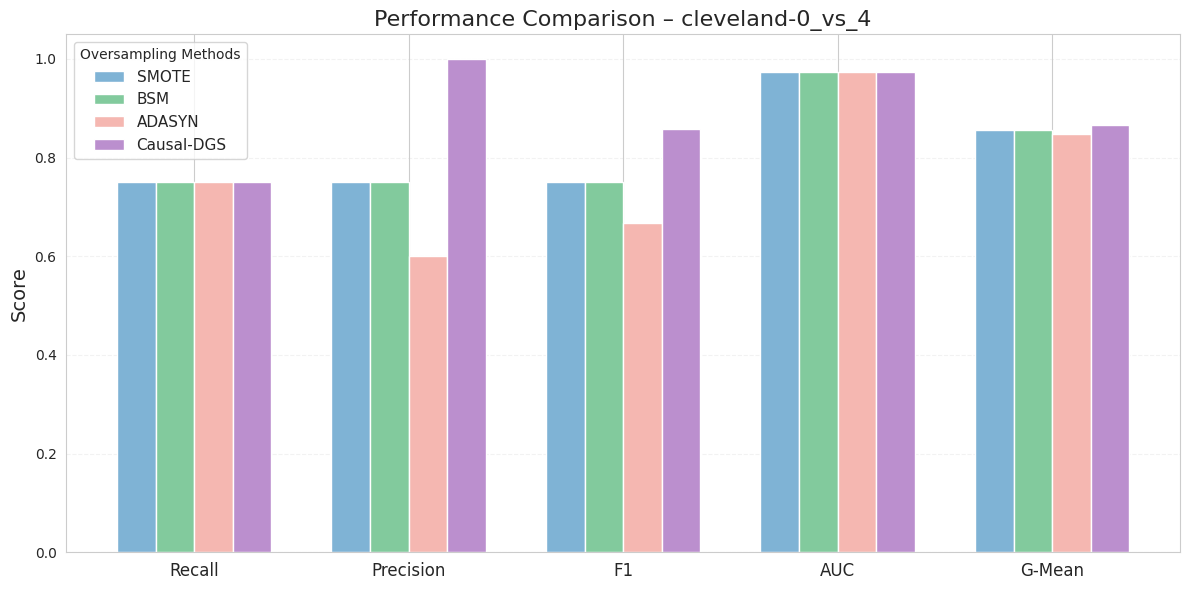

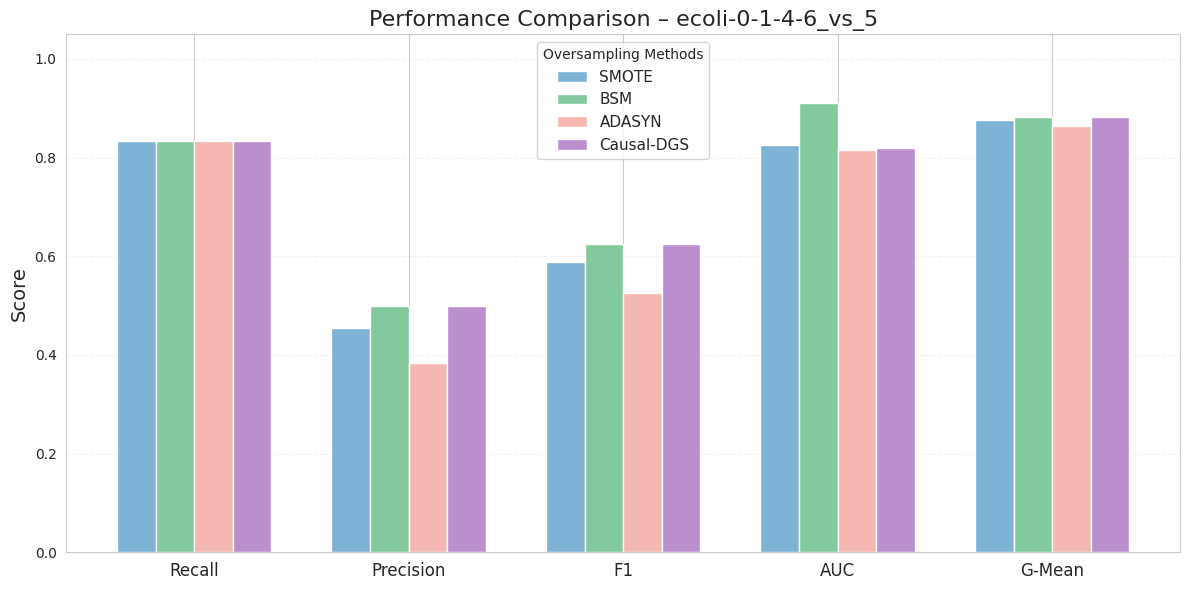

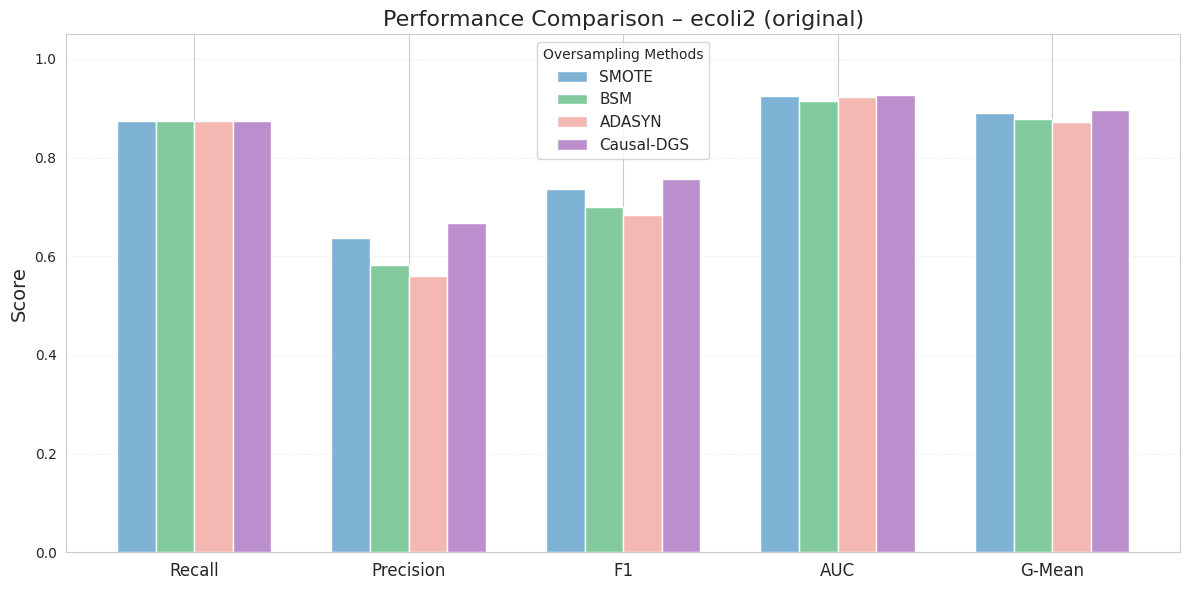

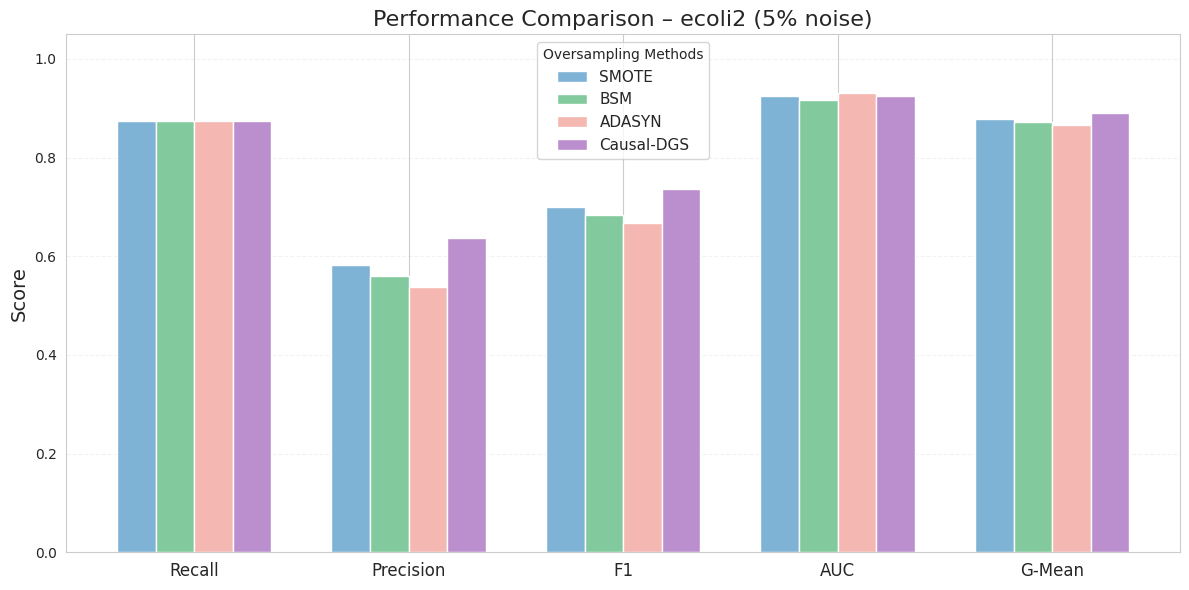

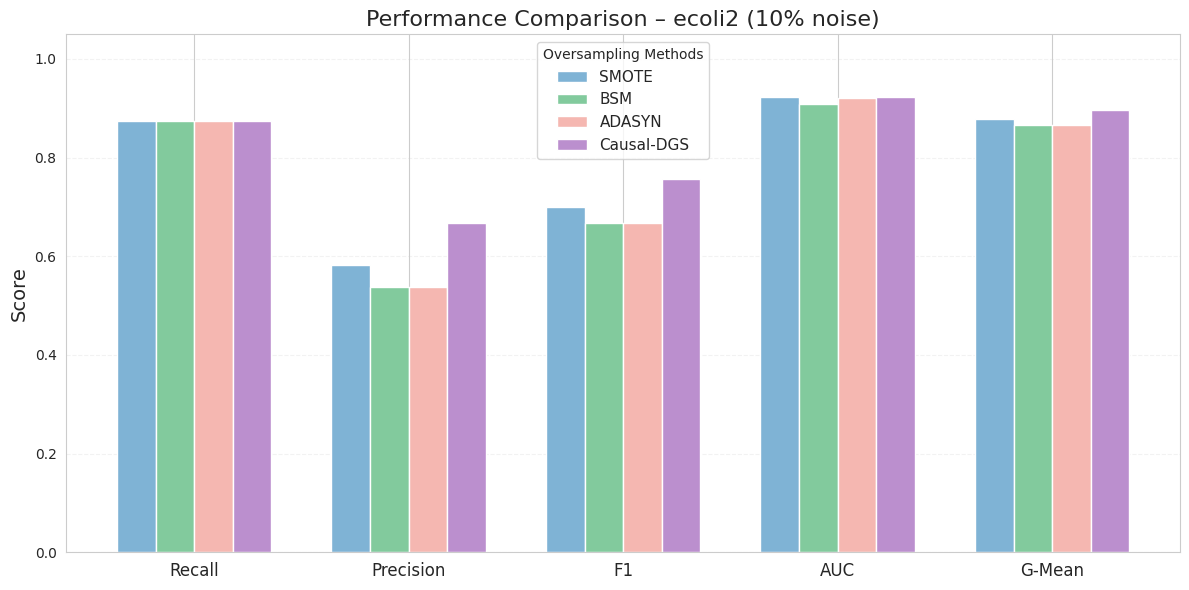

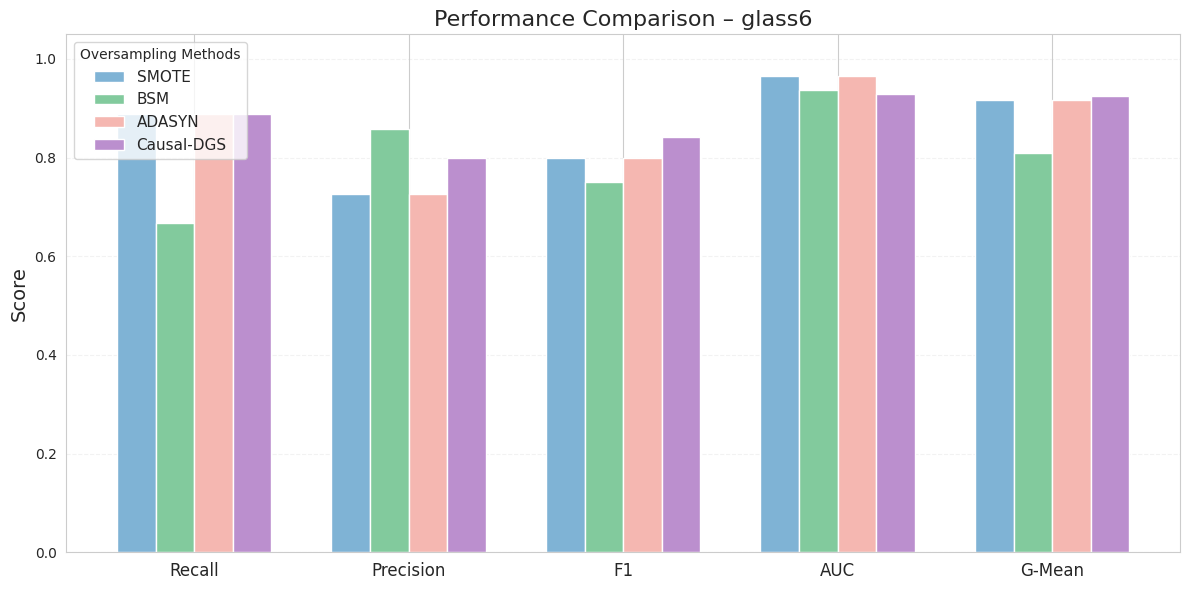

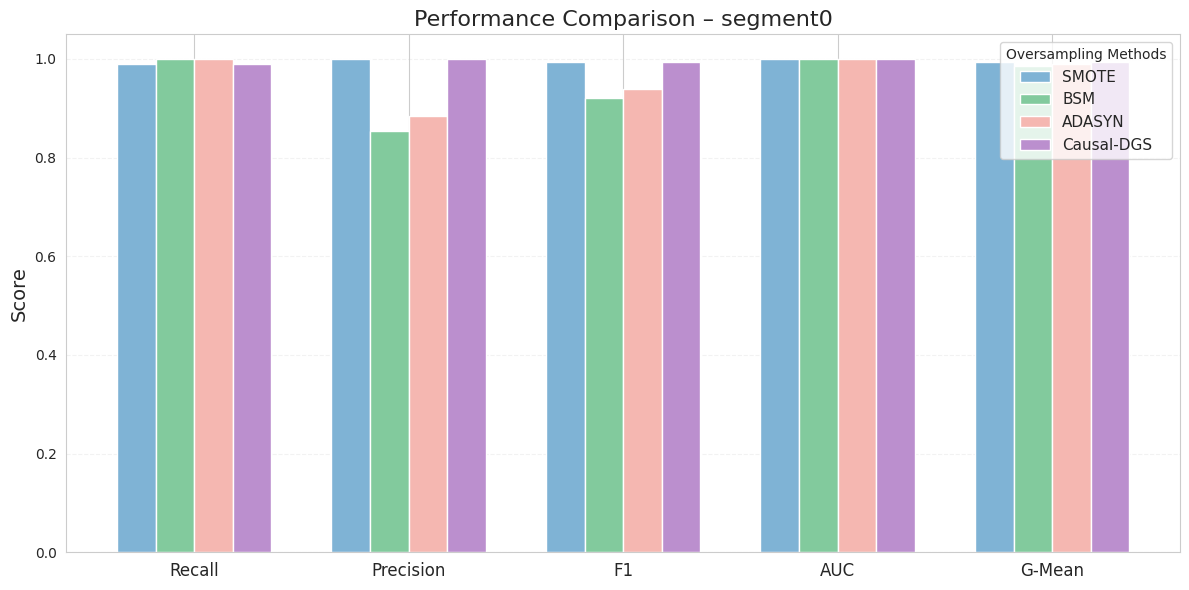

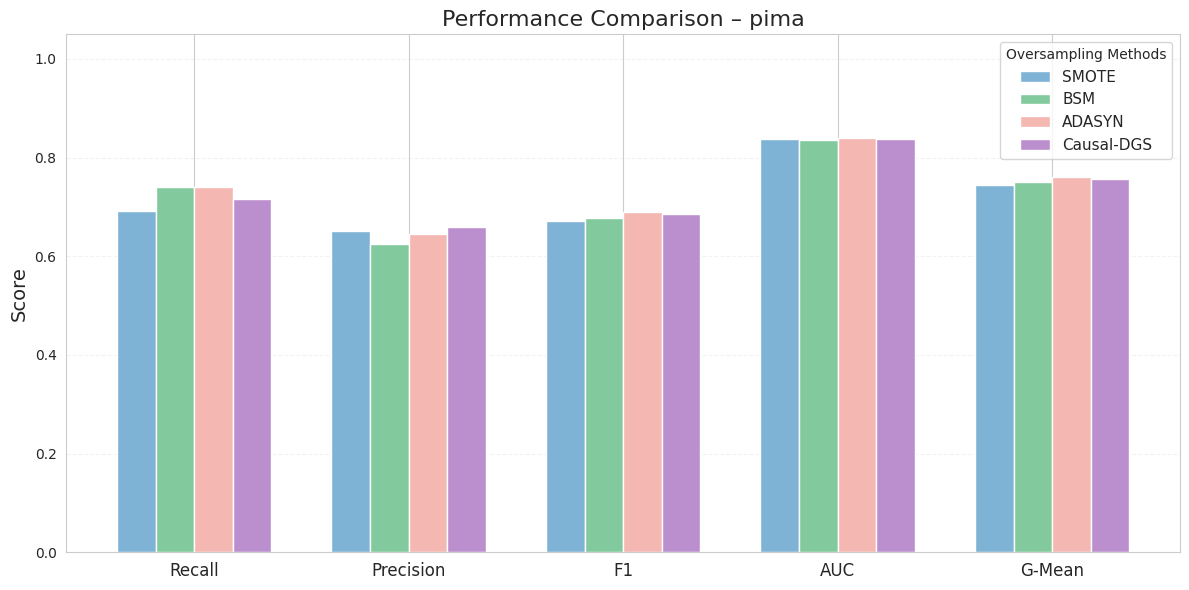

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pastel – academic color palette
colors = {
    "SMOTE": "#7FB3D5",      # pastel blue
    "BSM": "#82CA9D",        # pastel green
    "ADASYN": "#F5B7B1",     # pastel pink
    "Causal-DGS": "#BB8FCE"  # pastel lavender
}

# =============================
#  ALL DATASETS (FULL RESULTS)
# =============================
results = {
    "cleveland-0_vs_4": {
        "Recall":     [0.7500, 0.7500, 0.7500, 0.7500],
        "Precision":  [0.7500, 0.7500, 0.6000, 1.0000],
        "F1":         [0.7500, 0.7500, 0.6667, 0.8571],
        "AUC":        [0.9740, 0.9740, 0.9740, 0.9740],
        "G-Mean":     [0.8570, 0.8570, 0.8478, 0.8660],
    },

    "ecoli-0-1-4-6_vs_5": {
        "Recall":     [0.8333, 0.8333, 0.8333, 0.8333],
        "Precision":  [0.4545, 0.5000, 0.3846, 0.5000],
        "F1":         [0.5882, 0.6250, 0.5263, 0.6250],
        "AUC":        [0.8248, 0.9103, 0.8162, 0.8205],
        "G-Mean":     [0.8771, 0.8831, 0.8648, 0.8831],
    },

    "ecoli2 (original)": {
        "Recall":     [0.8750, 0.8750, 0.8750, 0.8750],
        "Precision":  [0.6364, 0.5833, 0.5600, 0.6667],
        "F1":         [0.7368, 0.7000, 0.6829, 0.7568],
        "AUC":        [0.9243, 0.9154, 0.9228, 0.9272],
        "G-Mean":     [0.8903, 0.8787, 0.8728, 0.8961],
    },

    "ecoli2 (5% noise)": {
        "Recall":     [0.8750, 0.8750, 0.8750, 0.8750],
        "Precision":  [0.5833, 0.5600, 0.5385, 0.6364],
        "F1":         [0.7000, 0.6829, 0.6667, 0.7368],
        "AUC":        [0.9250, 0.9162, 0.9301, 0.9243],
        "G-Mean":     [0.8787, 0.8728, 0.8669, 0.8903],
    },

    "ecoli2 (10% noise)": {
        "Recall":     [0.8750, 0.8750, 0.8750, 0.8750],
        "Precision":  [0.5833, 0.5385, 0.5385, 0.6667],
        "F1":         [0.7000, 0.6667, 0.6667, 0.7568],
        "AUC":        [0.9235, 0.9096, 0.9206, 0.9221],
        "G-Mean":     [0.8787, 0.8669, 0.8669, 0.8961],
    },

    "glass6": {
        "Recall":     [0.8889, 0.6667, 0.8889, 0.8889],
        "Precision":  [0.7273, 0.8571, 0.7273, 0.8000],
        "F1":         [0.8000, 0.7500, 0.8000, 0.8421],
        "AUC":        [0.9663, 0.9365, 0.9663, 0.9286],
        "G-Mean":     [0.9172, 0.8092, 0.9172, 0.9258],
    },

    "segment0": {
        "Recall":     [0.9899, 1.0000, 1.0000, 0.9899],
        "Precision":  [1.0000, 0.8534, 0.8839, 1.0000],
        "F1":         [0.9949, 0.9209, 0.9384, 0.9949],
        "AUC":        [0.9998, 1.0000, 1.0000, 0.9998],
        "G-Mean":     [0.9949, 0.9856, 0.9890, 0.9949],
    },

    "pima": {
        "Recall":     [0.6914, 0.7407, 0.7407, 0.7160],
        "Precision":  [0.6512, 0.6250, 0.6452, 0.6591],
        "F1":         [0.6707, 0.6780, 0.6897, 0.6864],
        "AUC":        [0.8384, 0.8358, 0.8393, 0.8374],
        "G-Mean":     [0.7437, 0.7503, 0.7601, 0.7569],
    },
}

methods = ["SMOTE", "BSM", "ADASYN", "Causal-DGS"]
metrics = ["Recall", "Precision", "F1", "AUC", "G-Mean"]

# =============================
#  PLOTTING
# =============================

for dataset, data in results.items():

    plt.figure(figsize=(12, 6))

    x = np.arange(len(metrics))
    width = 0.18

    for i, method in enumerate(methods):
        values = [data[m][i] for m in metrics]
        plt.bar(x + i*width, values, width, label=method, color=colors[method])

    plt.xticks(x + width*1.5, metrics, fontsize=12)
    plt.ylim(0, 1.05)
    plt.ylabel("Score", fontsize=14)
    plt.title(f"Performance Comparison – {dataset}", fontsize=16)

    plt.legend(title="Oversampling Methods", fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.25)

    plt.tight_layout()
    plt.show()